cane position x 80.0
sign -1
shoot position y 33.38146323817752
shoot size x 40.0
sign 1
shoot position y 54.97927478935622
shoot size x 40.0
sign 1
shoot position y 33.943664145990745
shoot size x 40.0
sign 1
shoot position y 26.05064739014416
shoot size x 40.0
sign -1
shoot position y 37.731714858749434
shoot size x 40.0
Number of leaves 100


<IPython.core.display.Javascript object>


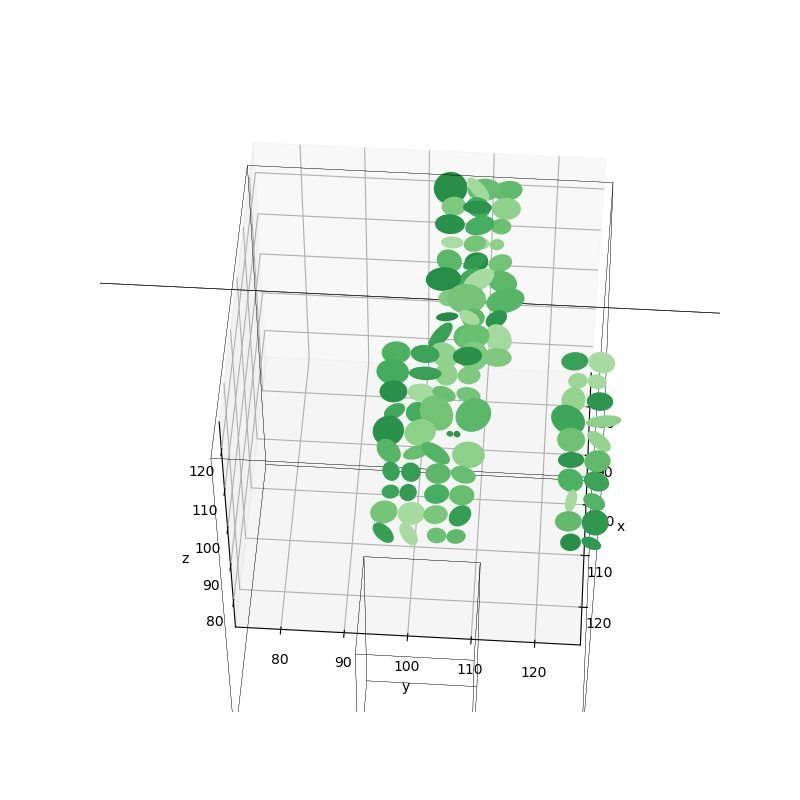

In [1]:
%matplotlib notebook
import plantrt as rt
import scene_conf as conf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from visualise import *
from matplotlib.patches import Circle, PathPatch
import numpy as np
      

pars = {'theta_sun':np.pi*.3,
        'phi_sun':2*
        np.pi/3.,
        'nscat': 50,
       'scene_extent':[200,200,200],
       'logfile': 'out.log',
       'nplevels':8}


scene_extent = pars['scene_extent']

scene = conf.default_scene_elements(scene_extent)

colors = {'canopy': 'green',
         'trunk': 'brown',
         'ground': 'orange'}

fig = plt.figure(2,figsize=(8,8))
ax = fig.gca(projection='3d')

scene['type'].append('bbox')
scene['bounds'].append([[0,0,-.1],[scene_extent[0],scene_extent[1],0.0]])
scene['name'].append('ground')

idbox = np.where(np.array(scene['type']) == 'bbox')[0]
nboxes = len(idbox)


if nboxes == 0:
    print ('No bounding boxes found!')
else:
    for ibox in range(nboxes):
        idd  = idbox[ibox]
        size = [[(scene['bounds'][idd][1][x] - scene['bounds'][idd][0][x]) for x in range(3)]]
        ppos  = [[(scene['bounds'][idd][1][x] + scene['bounds'][idd][0][x])/2. - size[0][x]/2.  for x in range(3)]]
        col  = [colors[scene['name'][idd].split('_')[0]]]
        #print (size)
        #print (pos)
        
        #size = [[10,10,10]]
        #pos  = [[10,10,10]]
        
        pc = plotCubeAt(ppos, sizes=size, colors=col,edgecolor="k",
                        linewidth=0.2,alpha=0., zorder =1 if scene['name'][idd] == 'ground' else 2 )
        ax.add_collection3d(pc)
    
    for leaf in scene['canopy']:
        if leaf == []:
            continue
        nleaves = len(leaf['center'])
        for il in range(nleaves):
            color=plt.cm.Greens(np.linspace(0.35,0.75, num=50))
            th = leaf['normal'][il][0]
            ph = leaf['normal'][il][1]
            normal = [np.sin(th)*np.cos(ph), np.sin(th)*np.sin(ph),
                     np.cos(th)]
            plot_disk(ax, leaf['center'][il], normal, leaf['radius'][il],
                      color=color[np.random.randint(0,50)])


ax.set_xlim([0,scene_extent[0]])
ax.set_ylim([0,scene_extent[1]])
ax.set_zlim([0,scene_extent[2]])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
nscatter = pars['nscat']

In [ ]:
%debug

In [ ]:
nphotons,pos, ray = rt.run(pars, verbose=True)
print (nphotons)
print (pos[-1])


In [ ]:
ray.prog

In [ ]:
print (len(pos))
pos[0] = [pos[0]]
lpos = [len(x) for x in pos]
print(lpos)
print (pos[0])

In [ ]:
pos[0] 
lpos = np.array([len(x) for x in pos])
raycol = plt.cm.coolwarm(np.linspace(0,1,nphotons))

for ip in range(nphotons):
    sel = np.where(lpos >= ip+1)[0]
    nsel = len(sel)
    
    xpos = [pos[sel[i]][ip][0] for i in range(nsel)]
    ypos = [pos[sel[i]][ip][1] for i in range(nsel)]
    zpos = [pos[sel[i]][ip][2] for i in range(nsel)]

    ax.plot(xpos,ypos,zpos,color=raycol[ip],linewidth=3,label=f'Generation {ip}')
    if ip == 0:
        ax.plot([xpos[0], xpos[0]],[ypos[0],ypos[0]],
                [zpos[0],zpos[0]],color=raycol[ip],marker='o')
    a = Arrow3D([xpos[-2], xpos[-1]], [ypos[-2], ypos[-1]], 
                [zpos[-2], zpos[-1]], mutation_scale=20, 
                lw=1, arrowstyle="-|>",color=raycol[ip])
    ax.add_artist(a)
ax.legend()    

In [ ]:
%matplotlib notebook 
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation


raydict = {}
id_start = np.zeros(nphotons) # scattering id where each photon emerges
ids0 = np.zeros(nphotons)
lpos = np.array([len(x) for x in pos])
raycol = plt.cm.autumn(np.linspace(0.1,.9,nphotons))
ik = 0

for ip in range(nphotons):
    sel = np.where(lpos > ip)[0]
    nsel = len(sel)
    print (nsel)
    id_start[ip] = sel[0]# - np.sum(id_start[0:ip])
    ids0[ip] = sel[0]

id_frame = np.zeros(nphotons) # frame at which photons emerge (converts id_start into frame number)
idf0 = np.zeros(nphotons)
allfr = 0
for ip in range(nphotons):
    sel = np.where(lpos > ip)[0]
    nsel = len(sel)
    
    xpos = [pos[sel[i]][ip][0] for i in range(nsel)]
    ypos = [pos[sel[i]][ip][1] for i in range(nsel)]
    zpos = [pos[sel[i]][ip][2] for i in range(nsel)]
    
    
    d_frame = 5.0
    dd = [np.sqrt((xpos[i+1] - xpos[i])**2 + (ypos[i+1]-ypos[i])**2 + (zpos[i+1]-zpos[i])**2) 
      for i in range(nsel-1)] 

    xf = []
    yf = []
    zf = []

    xf.append(xpos[0])
    yf.append(ypos[0])
    zf.append(zpos[0])

    kf = 0
    for i in range(nsel-1):
        nf = dd[i]/d_frame
        mm = np.array([xpos[i+1]-xpos[i], ypos[i+1]-ypos[i], zpos[i+1]-zpos[i]])/dd[i]

        if ip == 0: # first photon is in all frames
            sel = np.where(i == ids0)[0]
            if len(sel >0):
                id_frame[sel] = kf
                
        #if ip < nphotons-1:
        #    if i == id_start[ip+1]:
        #        id_frame[ip+1] = np.sum(id_frame[0:ip+1]) + kf 
        #        print (f'photon {ip} appears in frame {id_frame[ip]}')

        for j in range(int(np.round(nf))):
            xf.append(xpos[i] + d_frame*j*mm[0])
            yf.append(ypos[i] + d_frame*j*mm[1])
            zf.append(zpos[i] + d_frame*j*mm[2])
            kf += 1    
            
                            
    raydict['photon_%d'%ip] =np.array([xf,yf,zf])
    allfr += len(xf)
    #raydict['photon_%d'%ip] = np.array([[xpos,ypos,zpos], [xpos,ypos,zpos]])
 
nframes = len(raydict['photon_0'][0])
print (nframes)


In [ ]:
print (id_start)
print (id_frame)


In [ ]:
print (f'nphotons {nphotons}')

fig = plt.figure(1234,figsize=(5,5))
ax = p3.Axes3D(fig)
lines1 = [ax.plot(raydict[x][0, 0:1], raydict[x][1, 0:1], raydict[x][2, 0:1])[0] for x in raydict]
lines2 = [ax.plot(raydict[x][0, 0:1], raydict[x][1, 0:1], raydict[x][2, 0:1])[0] for x in raydict]
lines = lines1 + lines2
print (nframes)

In [ ]:
lines

In [ ]:
def update_single_phot(ip,nn, datalines, lines, color='blue'):
#    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
    for i in range(2):
    #    for data, line in zip(datalines, lines):
#        if i == 0:
#            orig = 0 if nn < 1 else nn-1
#            end = nn
#        else:
        orig = 0 if nn < (3*i+2) else nn-(3*i+2)
        end = nn if nn < 2 else nn-1
        lines[2*ip+i].set_data(datalines[0:2, orig:end])
        lines[2*ip+i].set_3d_properties(datalines[2, orig:end])
        if i == 0:
            lines[2*ip+i].set_marker('*')
            if ip == 0:
                lines[2*ip+i].set_markersize(10)
            else:
                lines[2*ip+i].set_markersize(5)
        else:
            lines[2*ip+i].set_alpha(0.4)
            
        lines[2*ip+i].set_linewidth(1)
        lines[2*ip+i].set_color(color)
#        i += 1
        
    
    return lines

def update_ray(num, datalines, lines):
    #print ('hello')
    for ip in range(nphotons):
        if int(num) >= int(id_frame[ip]):
         #   print (f'num-id_frame {num-id_frame[ip]}')
            lines = update_single_phot(ip,int(int(num)-id_frame[ip]),
                        datalines['photon_%d'%ip], lines, color=raycol[ip])
    
    ax.view_init(elev=np.abs(10+ 5*np.sin(num/200.0)), azim=num*0.3)
    
    return lines

In [ ]:
# Attaching 3D axis to the figure
#ax.set_aspect('equal')


scene = conf.default_scene_elements(scene_extent)

idbox = np.where(np.array(scene['type']) == 'bbox')[0]
nboxes = len(idbox)

colors = {'canopy': 'green',
         'trunk': 'brown'}


if nboxes == 0:
    print ('No bounding boxes found!')
else:
    for ibox in range(nboxes):
        idd  = idbox[ibox]
        size = [[(scene['bounds'][idd][1][x] - scene['bounds'][idd][0][x]) for x in range(3)]]
        poss  = [[(scene['bounds'][idd][1][x] + scene['bounds'][idd][0][x])/2. - size[0][x]/2.  for x in range(3)]]
        col  = [colors[scene['name'][idd].split('_')[0]]]
        pc = plotCubeAt(poss, sizes=size, colors=col,edgecolor="k",linewidth=0.1, alpha=0.5)
        ax.add_collection3d(pc)


# Setting the axes properties
ax.set_xlim3d([0.0, scene_extent[0]])
ax.set_xlabel('X')

ax.set_ylim3d([0.0, scene_extent[1]])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, scene_extent[2]])
ax.set_zlabel('Z')
#ax.set_axis_off()

#ax.set_title('3D Test')

# Creating the Animation object

line_ani = animation.FuncAnimation(fig, update_ray, nframes, fargs=(raydict, lines),
                                   interval=50, blit=True, repeat=True)

In [ ]:
#update_ray(21,raydict, lines)

In [ ]:
#print ((raydict['photon_0'][1][2,0:200]))




In [ ]:
#line_ani
line_ani.save('line_animation_3d_funcanimation.gif', writer='imagemagick',fps=20)
#line_ani.save('line_animation_3d_funcanimation.mpg', writer='ffmpeg',fps=10)
